# Get trailer list

Given the list of movie titles, get the corresponding trailer id and statistics using Youtube Data API.
- Use the 'search' module of Youtube Data API to search the trailers for a movie.
- Use the 'videos' module of Youtube Data API to get the statistics (view count, comment count, etc) for each trailer.
- One movie may have multiple trailers. Store all the trailer info in a df.
- Prune the trailer list.

In [1]:
import pandas as pd
import time
import json
import matplotlib.pyplot as plt

from multiprocessing import Pool, cpu_count

from apiclient.discovery import build
from youtube_api import *

# for auto reload a module after editing.
%load_ext autoreload
%autoreload 2

In [3]:
key_file_0 = "./private_api_key/youtube_data_API_key.txt"
api_key_0 = open(key_file_0, "r").read()
youtube_0 = build('youtube', 'v3', developerKey=api_key_0)

key_file_list = "./private_api_key/youtube_data_API_key_list.txt"
api_key_list = [k for k in open(key_file_list, "r").read().split('\n') if len(k) > 15]
youtube_list = [build('youtube', 'v3', developerKey=k) for k in api_key_list]

In [6]:
movie_df = pd.read_csv("./data/movie_list/metadata_2014-2019.csv")

In [7]:
movie_df.shape

(705, 16)

### Step 1: Search all trailer candidates

In [72]:
trailer_df = pd.DataFrame(columns=['tt_id', 'movie_title', 'release_date', \
                                   'trailer_id', 'trailer_publishTime', 'trailer_title',\
                                   'viewCount', 'commentCount', 'likeCount', 'dislikeCount', 'favoriteCount'
                                  ])

In [73]:
row = 0
for i in range(0, movie_df.shape[0]):
    youtube = youtube_list[int(i/70)]
    tt_id = movie_df.tt_id.iloc[i]
    movie_name = movie_df.Title.iloc[i]
    if movie_name == "Birdman or (The Unexpected Virtue of Ignorance)":
        movie_name = "Birdman"
    movie_release_date = movie_df.release_date.iloc[i]
    trailer_dict, _ = get_trailer_ids(movie_name, movie_release_date, 7, youtube)
    for v_id in trailer_dict:
        trailer_df.loc[row, 'tt_id'] = tt_id
        trailer_df.loc[row, 'movie_title'] = movie_name
        trailer_df.loc[row, 'release_date'] = movie_release_date
        trailer_df.loc[row, 'trailer_id'] = v_id
        trailer_df.loc[row, 'trailer_publishTime'] = trailer_dict[v_id][0]
        trailer_df.loc[row, 'trailer_title'] = trailer_dict[v_id][1]
        v_stat = get_trialer_statistics(v_id, youtube)
        for item in v_stat:
            trailer_df.loc[row, item] = int(v_stat[item])
        row += 1

In [75]:
trailer_df.to_csv("./data/trailer_list/trailer_list_raw.csv", index=False)

In [102]:
trailer_df.columns

Index(['tt_id', 'movie_title', 'release_date', 'trailer_id',
       'trailer_publishTime', 'trailer_title', 'viewCount', 'commentCount',
       'likeCount', 'dislikeCount', 'favoriteCount'],
      dtype='object')

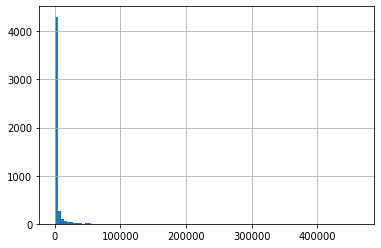

In [110]:
trailer_df.commentCount.hist(bins=100)

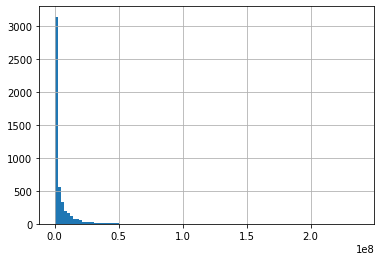

In [112]:
trailer_df.viewCount.hist(bins=100)

### Step 2: Remove videos with viewCount < 10k
- Result saved as "./data/trailer_list/trailer_list_prune1.csv"

In [122]:
df_prune1 = pd.read_csv("./data/trailer_list/trailer_list_raw.csv")
print(df_prune1.shape)

(4955, 11)


In [123]:
df_prune1 = df_prune1[df_prune1.viewCount >= 1e5]
print(df_prune1.shape)

(3858, 11)


In [124]:
df_prune1.to_csv("./data/trailer_list/trailer_list_prune1.csv", index=False)

### Step 3: Manaully clean up unrelevent videos
- Check each trailer title use movie_title_key_words.
- Remove the trailers whose title doesn't contains all the key_words.
- Result saved as "./data/trailer_list/trailer_list_prune2.csv"

In [130]:
movie_title_key_words = pd.DataFrame(columns=['movie_title', 'key_words'])
movie_title_key_words.movie_title = df_prune1.movie_title.unique()
movie_title_key_words.key_words = df_prune1.movie_title.unique()
# movie_title_key_words.to_csv("./data/trailer_list/movie_title_key_words.csv", index=False)
# Then manaully set the key words for each movie_title.

In [181]:
df_prune2 = pd.read_csv("./data/trailer_list/trailer_list_prune1.csv")
movie_title_key_words = pd.read_csv("./data/trailer_list/movie_title_key_words.csv")
df_prune2.loc[:, 'remove'] = False

In [182]:
df_prune2.columns

Index(['tt_id', 'movie_title', 'release_date', 'trailer_id',
       'trailer_publishTime', 'trailer_title', 'viewCount', 'commentCount',
       'likeCount', 'dislikeCount', 'favoriteCount', 'remove'],
      dtype='object')

In [183]:
for i in range(df_prune2.shape[0]):
    movie_title = df_prune2.loc[i, 'movie_title']
    key_words = movie_title_key_words[movie_title_key_words.movie_title == movie_title].key_words.iloc[0]
    key_words = key_words.lower().split(',')
    trailer_title = df_prune2.loc[i, 'trailer_title'].lower()
    df_prune2.loc[i, 'remove'] = not all([k in trailer_title for k in key_words])
df_prune2 = df_prune2[df_prune2.remove == False]
print(df_prune2.shape)
print(df_prune2.movie_title.nunique())

(3702, 12)
739


In [189]:
df_prune2 = df_prune2.sort_values(['release_date', 'tt_id', 'trailer_publishTime'])
df_prune2.to_csv("./data/trailer_list/trailer_list_prune2.csv", index=False)

### Step 4: Keep atmost 3 trailers for each movie
- Find the most view trailer of the movie.
- For the rest trailers, if the viewCount < 0.1 * most viewed trailer's viewCount, remove if.
- If the remaining trailer number is still larger than 3, only keep the top 3 trialers
- Result saved as "./data/trailer_list/trailer_list_prune3.csv"

In [218]:
df_prune3 = pd.read_csv("./data/trailer_list/trailer_list_prune2.csv")

In [219]:
max_viewCount_df = df_prune3.groupby("tt_id").agg({
    "viewCount": "max"
})

In [220]:
df_prune3.loc[:, 'remove'] = False
for i in range(df_prune3.shape[0]):
    tt_id = df_prune3.loc[i, 'tt_id']
    viewCount = df_prune3.loc[i, 'viewCount']
    max_viewCount = max_viewCount_df.loc[tt_id, 'viewCount']
    if 10 * viewCount < max_viewCount:
        df_prune3.loc[i, 'remove'] = True
df_prune3 = df_prune3[df_prune3.remove == False]
print(df_prune3.shape)

(2326, 12)


In [221]:
df_prune3 = df_prune3.sort_values(['release_date', 'tt_id', 'viewCount'])
df_prune3 = df_prune3.groupby('tt_id').tail(3).reset_index(drop=True)
print(df_prune3.shape)
print(df_prune3.movie_title.nunique())
df_prune3 = df_prune3.sort_values(['release_date', 'tt_id', 'trailer_publishTime'])
df_prune3.to_csv("./data/trailer_list/trailer_list_prune3.csv", index=False)

(1903, 12)
739


### Step 5: Find out the trailers which disable comments


In [12]:
df_prune4 = pd.read_csv("./data/trailer_list/trailer_list_prune3.csv")
df_prune4 = df_prune4.drop(columns=['favoriteCount', 'remove'])
df_prune4.loc[:, 'comment_disabled'] = False
df_prune4.loc[:, 'year'] = df_prune4.loc[:, 'release_date'].apply(lambda x: int(x[:4]))
df_prune4.loc[:, 'month'] = df_prune4.loc[:, 'release_date'].apply(lambda x: int(x[5:7]))
# df_prune4.loc[:, 'day'] = df_prune4.loc[:, 'release_date'].apply(lambda x: int(x[-2:]))

In [13]:
def func(df):
    for i in range(df.shape[0]):
        video_id = df.loc[i, 'trailer_id']
        movie_title = df.loc[i, 'movie_title']
        try:
            res = get_comment_thread_1page(video_id, youtube_0)
        except:
            print("Comments are turned off for {}. Movie: {}".format(video_id, movie_title))
            df.loc[i, 'comment_disabled'] = True
    return df

In [14]:
t0 = time.time()
df = df_prune4.loc[:, :]
with Pool(cpu_count()) as p:
    chunks = p.map(func, [df[df['month'] == i].reset_index(drop=True) for i in range(1, 13)])
t1 = time.time()
print('Finished. Time: {:.1f} s.'.format(t1 - t0))
df_filled = pd.DataFrame()
for chunk in chunks:
    df_filled = pd.concat([df_filled, chunk])
df_filled = df_filled.sort_values(['release_date', 'tt_id', 'trailer_publishTime'])
df_filled = df_filled.reset_index(drop=True)

Comments are turned off for 9iGwEp_A0PY. Movie: Mr. Peabody & Sherman
Comments are turned off for lPnY2NjSjrg. Movie: The Lego Movie
Comments are turned off for fZ_JOBCLF-I. Movie: The Lego Movie
Comments are turned off for aMl2tTVwsZA. Movie: Mr. Peabody & Sherman
Comments are turned off for hUWsKkMKZBc. Movie: Rio 2
Comments are turned off for HXppfX-mBsE. Movie: Muppets Most Wanted
Comments are turned off for TGjbpO1toTc. Movie: The SpongeBob Movie: Sponge Out of Water
Comments are turned off for bNoBuZSX0Bg. Movie: The SpongeBob Movie: Sponge Out of Water
Comments are turned off for u8A_F5oYJGI. Movie: Norm of the North
Comments are turned off for Du4jTG7-93k. Movie: Home
Comments are turned off for 10r9ozshGVE. Movie: Kung Fu Panda 3
Comments are turned off for fGPPfZIvtCw. Movie: Kung Fu Panda 3
Comments are turned off for aBJyp2LFHgk. Movie: The Lego Batman Movie
Comments are turned off for iMdQXYQ_MD8. Movie: The Lego Batman Movie
Comments are turned off for rGQUKzSDhrg. Movie:

In [19]:
df_prune4 = df_filled.drop(columns=['year', 'month'])
df_prune4.to_csv("./data/trailer_list/trailer_list_2014-2019.csv", index=False)

In [31]:
df_prune4.commentCount.sum() / 60000

225.21